In [1]:
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, confusion_matrix, roc_curve

import xgboost as xgb

import datetime

In [3]:
with open('pickle/crime_borough_month_prev_year_values.pkl', 'rb') as picklefile:
    crime = pickle.load(picklefile)
    


In [4]:
with open('pickle/imd_borough_2010.pkl', 'rb') as picklefile:
    imd = pickle.load(picklefile)
    
with open('pickle/borough_year.pkl', 'rb') as picklefile:
    borough_year = pickle.load(picklefile)
    
with open('pickle/borough_non_year.pkl', 'rb') as picklefile:
    borough_non_year = pickle.load(picklefile)

In [5]:
crime = crime.merge(imd, on='borough')
crime = crime.merge(borough_non_year, on='borough')
crime = crime.merge(borough_year, on=['borough','year'])

crime2012_2016 = crime[crime['year']>2011].fillna(-9999999)

# Removing empty columns
crime2012_2016 = crime2012_2016[
    (crime2012_2016['minor_category'] != 'Counted per Victim') &
    (crime2012_2016['minor_category'] != 'Other Fraud & Forgery') &
    (crime2012_2016['minor_category'] != 'Other Sexual') &
    (crime2012_2016['minor_category'] != 'Rape')
]

In [34]:
crime_dist_borough = crime2012_2016.groupby('borough')['is_commited'].value_counts(normalize=True)

In [49]:
crime2012_2016.shape

(62760, 64)

In [51]:
# Checking for duplicates
crime2012_2016.drop_duplicates(subset=['borough','minor_category','datetime']).shape

(62760, 64)

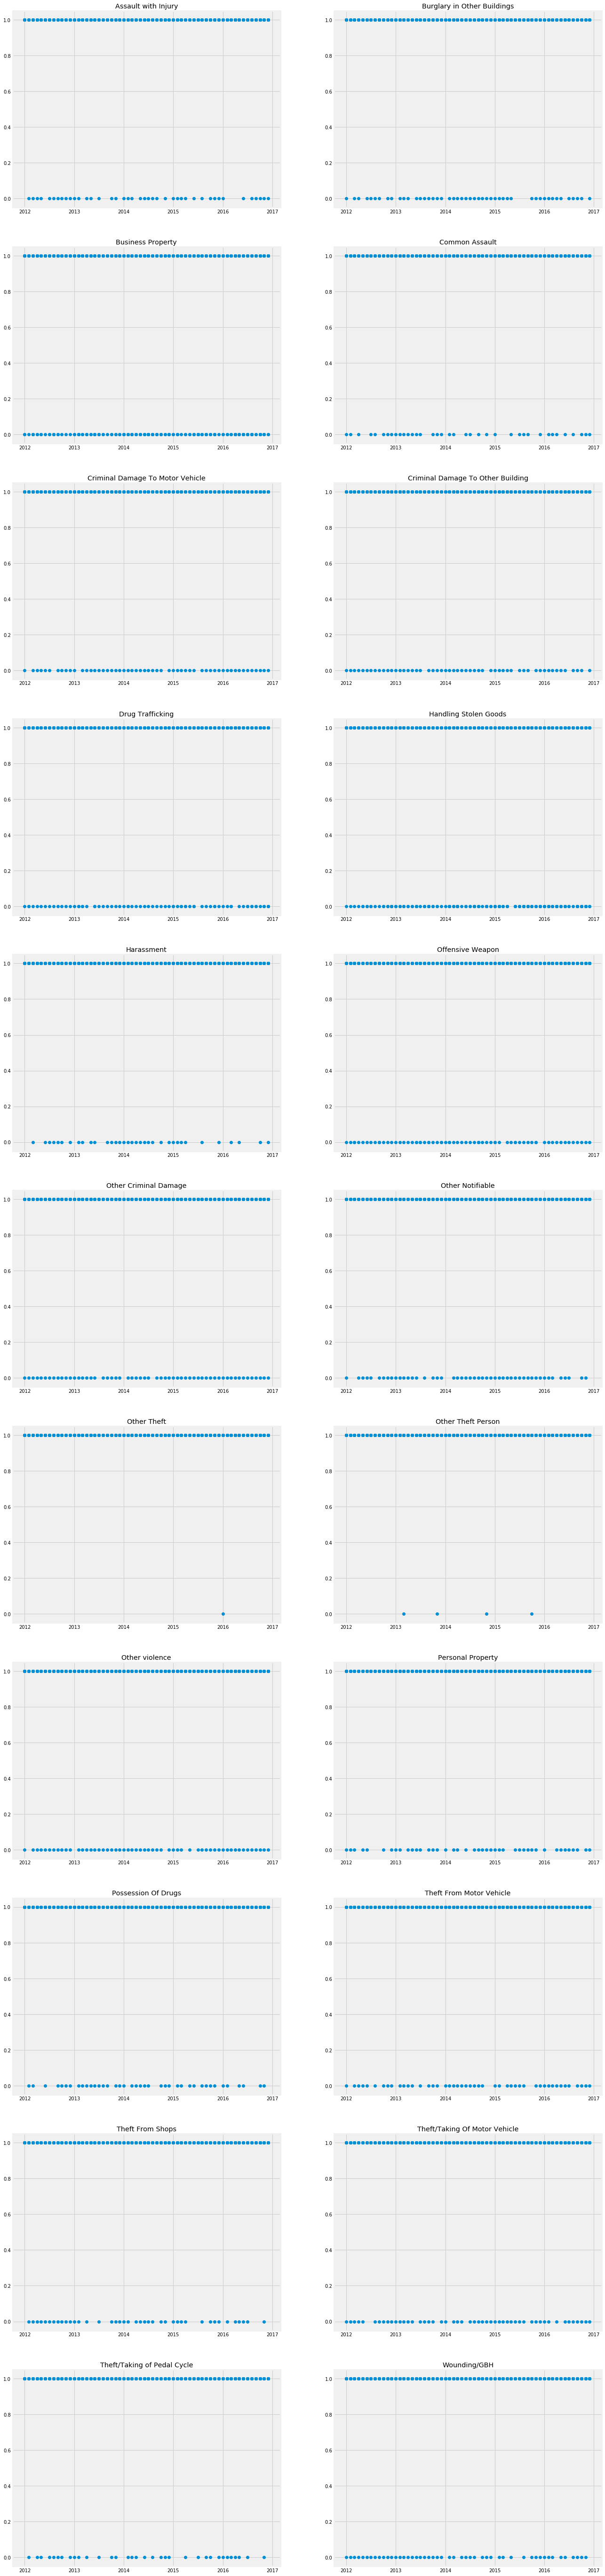

In [55]:
# Check target distribution for one borough among different crime categories
city = crime2012_2016[crime2012_2016['borough']=='City of London']
minor_categories = city['minor_category'].unique()
import math
plt.figure(figsize=[20,100])

for i in range(len(minor_categories)):
    plt.subplot(math.ceil(len(minor_categories)/2),2,i+1)
    crime = crime2012_2016[crime2012_2016['minor_category']==minor_categories[i]]
    plt.plot_date(crime['datetime'],crime['is_commited'])
    plt.title(minor_categories[i])

At least one crime    0.921895
No crimes             0.078105
Name: is_commited, dtype: float64


(array([0, 1]), <a list of 2 Text xticklabel objects>)

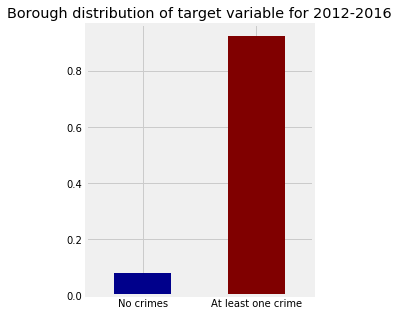

In [92]:
target_pcts = crime2012_2016['is_commited'].apply(lambda x: "No crimes" if x == 0 else "At least one crime").value_counts(normalize=True) 
print(target_pcts)

plt.figure(figsize = (8,5))

plt.subplot(1,2,1)
target_pcts.sort_values().plot(kind='bar',color=['darkblue','maroon'])
plt.title('Borough distribution of target variable for 2012-2016')
plt.xticks(rotation='horizontal')

## All variables

In [8]:
m_all = crime2012_2016.drop(['borough', 'minor_category', 'value', 'datetime'], axis=1)

train = m_all[m_all['year']<2016].drop(['year','month'],axis=1)
test = m_all[(m_all['year']==2016)].drop(['year','month'],axis=1)

X_train, y_train = train.drop('is_commited',axis=1), train['is_commited']
X_test, y_test = test.drop('is_commited',axis=1), test['is_commited']

xg = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                        #,scale_pos_weight = 0.25
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = xg.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

y_pred = xg.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_pred))
print(precision_score(y_test, (y_pred>0.5).astype(int)))
print(recall_score(y_test, (y_pred>0.5).astype(int)))
print(f1_score(y_test, (y_pred>0.5).astype(int)))
print(accuracy_score(y_test, (y_pred>0.5).astype(int)))

0.986001653424
0.978600176696
0.981780579082
0.980187798043
0.963416848221


In [9]:
# Checking overprediction
y_pred = xg.predict_proba(X_train)[:,1]

print(roc_auc_score(y_train, y_pred))
print(precision_score(y_train, (y_pred>0.5).astype(int)))
print(recall_score(y_train, (y_pred>0.5).astype(int)))
print(f1_score(y_train, (y_pred>0.5).astype(int)))
print(accuracy_score(y_train, (y_pred>0.5).astype(int)))

0.987553271437
0.980597565474
0.981587239071
0.98109215269
0.965118917938


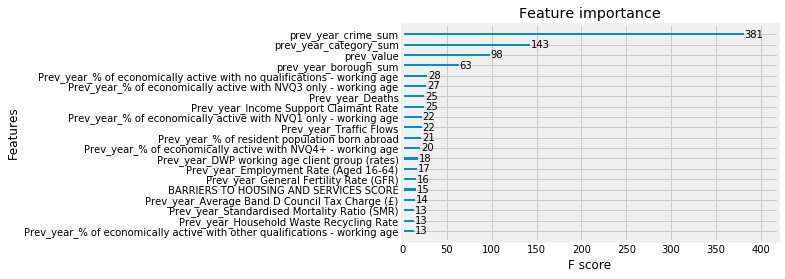

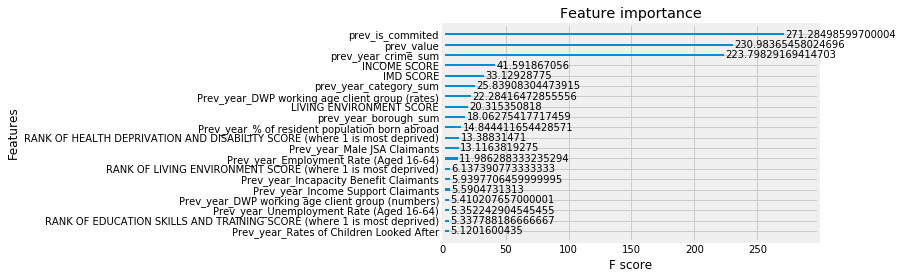

In [10]:
xgb.plot_importance(xg, max_num_features = 20)
xgb.plot_importance(xg, importance_type='gain', max_num_features = 20)

In [14]:
gain10 = gain.head(10)
gain10

,index,0
0,prev_is_commited,271.284986
1,prev_value,230.983655
2,prev_year_crime_sum,223.798292
3,INCOME SCORE,41.591867
4,IMD SCORE,33.129288
5,prev_year_category_sum,25.839083
6,Prev_year_DWP working age client group (rates),22.284165
7,LIVING ENVIRONMENT SCORE,20.315351
8,prev_year_borough_sum,18.062754
9,Prev_year_% of resident population born abroad,14.844412


In [22]:
variablenames = [
'Prev month target',
'Prev month crime value',
'Prev year by Borough & type',
'Income score',
'IMD score',
'Prev year category',
'Prev year people of working-age claiming benefits rates',
'Living environment score',
'Prev year borough',
'Prev year % of resident population born abroad'
]

In [23]:
gain = xg.get_booster().get_score(importance_type='gain')
gain = pd.DataFrame(gain, index=[0]).transpose().sort_values(by = 0, ascending = False).reset_index()

# To plot only top10 variables
gain10 = gain.head(10).sort_values(by=0,ascending=True).merge(pd.DataFrame({'index':gain.head(10)['index'],'new':variablenames}),on='index',how='left')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text yticklabel objects>)

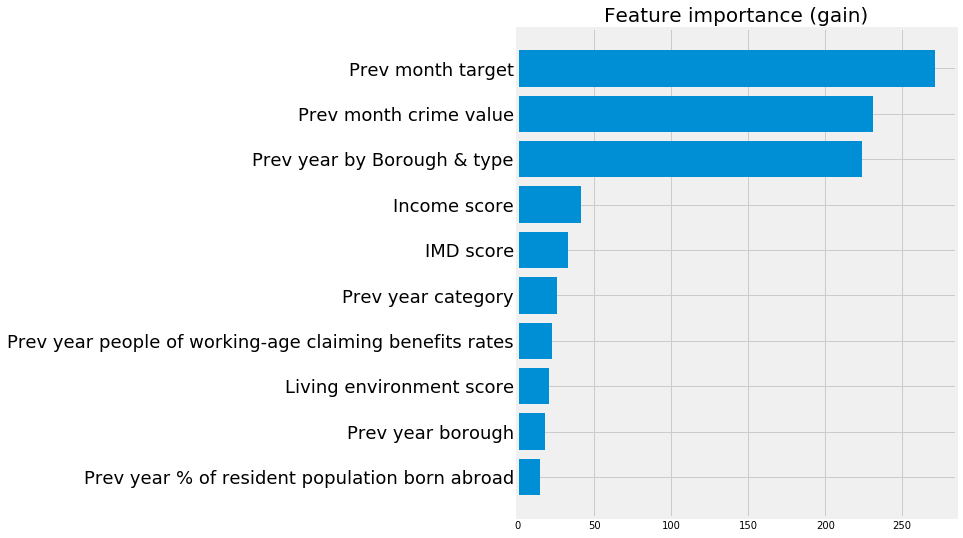

In [39]:
plt.figure(figsize =(7,9))
plt.barh(gain10['new'],gain10[0])
plt.title('Feature importance (gain)',fontsize = 20)
plt.yticks(fontsize=18)

In [131]:
# Keeping only variables that account for 90% of gain
gain = xg.get_booster().get_score(importance_type='gain')
gain = pd.DataFrame(gain, index=[0]).transpose().sort_values(by = 0, ascending = False).reset_index()
cutoff = gain[0].sum() * 0.90
gain['cumsum'] = gain[0].cumsum()

features_to_keep_borough = list(gain[gain['cumsum']<=cutoff]['index'])
features_to_keep_borough

['prev_is_commited',
 'prev_value',
 'prev_year_crime_sum',
 'INCOME SCORE',
 'IMD SCORE',
 'prev_year_category_sum',
 'Prev_year_DWP working age client group (rates)',
 'LIVING ENVIRONMENT SCORE',
 'prev_year_borough_sum',
 'Prev_year_% of resident population born abroad',
 'RANK OF HEALTH DEPRIVATION AND DISABILITY SCORE (where 1 is most deprived)',
 'Prev_year_Male JSA Claimants',
 'Prev_year_Employment Rate (Aged 16-64)',
 'RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived)',
 'Prev_year_Incapacity Benefit Claimants',
 'Prev_year_Income Support Claimants',
 'Prev_year_DWP working age client group (numbers)',
 'Prev_year_Unemployment Rate (Aged 16-64)',
 'RANK OF EDUCATION SKILLS AND TRAINING SCORE (where 1 is most deprived)',
 'Prev_year_Rates of Children Looked After',
 'HEALTH DEPRIVATION AND DISABILITY SCORE',
 "Simpson's Ethnic Diversity Index (16 ethnic groups)",
 'Prev_year_Gross Annual Pay - Full Time - Female (£)',
 'BARRIERS TO HOUSING AND SERVICES SCORE',
 'Prev_

In [120]:
# compare the model to what it had been if it was the same as last year

#print(roc_auc_score(y_test, X_test['prev_is_commited']))
print(precision_score(y_test, X_test['prev_is_commited']))
print(recall_score(y_test, X_test['prev_is_commited']))
print(f1_score(y_test, X_test['prev_is_commited']))
print(accuracy_score(y_test, X_test['prev_is_commited']))

0.97236478484
0.970066955494
0.971214511041
0.946986201888


## Comparing with LSOA model, same features

In [134]:
features_to_keep = ['prev_year_crime_sum',
 'prev_is_commited',
 'prev_year_category_sum',
 'prev_value',
 'RANK OF LIVING ENVIRONMENT SCORE (where 1 is most deprived)',
 'prev_year_borough_sum',
 'IMD SCORE',
 'RANK OF INCOME SCORE (where 1 is most deprived)',
 'RANK OF IMD SCORE (where 1 is most deprived)',
 'HEALTH DEPRIVATION AND DISABILITY SCORE',
 'LIVING ENVIRONMENT SCORE',
 'INCOME SCORE',
 'RANK OF EMPLOYMENT SCORE (where 1 is most deprived)',
 'Population',
 'CRIME AND DISORDER SCORE',
 'Prev_year_Deaths',
 'EMPLOYMENT SCORE',
 'Prev_year_Standardised Mortality Ratio (SMR)',
 'Prev_year_Rates of Children Looked After',
 'is_commited']

In [135]:
# Comparison with the lsoa model
features_to_keep2 = features_to_keep + ['year','month']
m_relevant = crime2012_2016[features_to_keep2]

train = m_relevant[m_relevant['year']<2016].drop(['year','month'],axis=1)
val = m_relevant[(m_relevant['year']==2016) & (m_relevant['month']<7)].drop(['year','month'],axis=1)
test = m_relevant[(m_relevant['year']==2016) & (m_relevant['month']>6)].drop(['year','month'],axis=1)

X_train, y_train = train.drop('is_commited',axis=1), train['is_commited']
X_val, y_val = val.drop('is_commited',axis=1), val['is_commited']
X_test, y_test = test.drop('is_commited',axis=1), test['is_commited']

xg_relevant = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                        #,scale_pos_weight = 0.25
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = xg_relevant.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

y_pred = xg_relevant.predict_proba(X_val)[:,1]

print(roc_auc_score(y_val, y_pred))
print(precision_score(y_val, (y_pred>0.5).astype(int)))
print(recall_score(y_val, (y_pred>0.5).astype(int)))
print(f1_score(y_val, (y_pred>0.5).astype(int)))
print(accuracy_score(y_val, (y_pred>0.5).astype(int)))

0.986759815617
0.980349774022
0.982860520095
0.981603541564
0.966049382716
